First we will import our packages. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms

With everything imported succesfully, let's generate our data.

In [ ]:
def spirals(points, noise=.5):
    n = np.sqrt(np.random.rand(points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(points),np.ones(points))))


X, y = spirals(1000)
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))

(2000, 2)
(2000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


After generating data we want to split it, so we have data that will be used for training and data for testing, we want to see how our model is performing on data it hasn't seen before. The test size will be 20% and our training data will be 80%.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's check out our data point and how they look. They are different colors, because they are split into two classes.

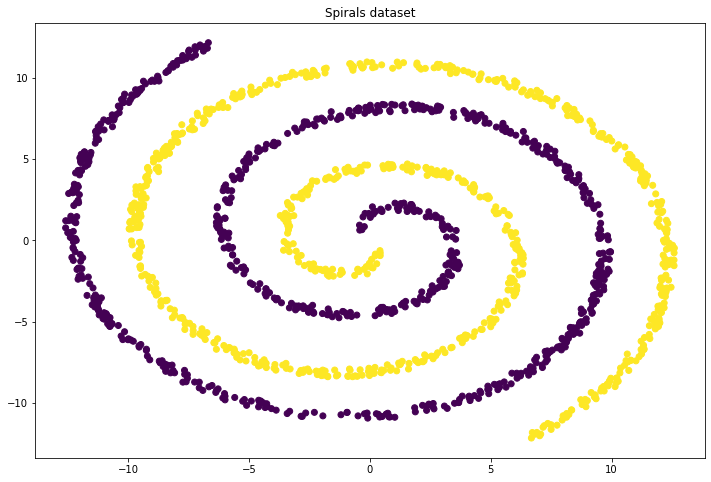

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.title('Spirals dataset')
plt.show()

We can see that our data was succesfully split into training and testing. By printing the shapes we can see that the X for training has 1600 points that are 2D, and also for training we have 1600 labels which tell us in which class does a point belong to. For testing we have 400 points that are also 2D and 400 labels which correspond to those points.

In [ ]:
print('x_train:\t{}' .format(X_train.shape))
print('y_train:\t{}' .format(y_train.shape))
print('x_test:\t\t{}'.format(X_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(1600, 2)
y_train:	(1600,)
x_test:		(400, 2)
y_test:		(400,)


We have already created a Shallow Neural Network earlier in this post, but because the data is now a little bit complex we will add another hidden layer, for better predictions. We will have 4 Fully Connected layers or Linear, 3 of which will have ReLu activation fucntions except for the last one which will have a sigmoid to tell us where the network thinks in which class a point belongs to.

In [ ]:
class ShallowNeuralNetwork(nn.Module):
  def __init__(self):
    super(ShallowNeuralNetwork, self).__init__()

    self.linear = nn.Sequential(
        nn.Linear(2, 12),
        nn.ReLU(),

        nn.Linear(12, 12),
        nn.ReLU(),
        
        nn.Linear(12, 12),
        nn.ReLU(),

        nn.Linear(12, 1),
        nn.Sigmoid()
    )
  
  def forward(self, x):
    x = self.linear(x) # Pass the data throught the linear layer
    return x

We will call our Neural Net and print it to see how our layers look.

In [ ]:
model = ShallowNeuralNetwork()
print(model)

ShallowNeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


As mentioned earlier the network takes an input and spits out a predictions. But, the input needs to be a Tensor, for now it is just an numpy array. By calling torch's FloatTensor() function we can transform any point into a tensor of floating points. Let's do a quick example.

We will create a variable x which will be the size [1, 1] and immediately pass it into the torch.FloatTensor() to make it a tensor. We pass this into the network and get a prediction.

In [ ]:
x = torch.FloatTensor([1, 1])
model(x)

tensor([0.4757], grad_fn=<SigmoidBackward>)

The grad_fn represents autograd package which provides automatic differentiation for all operations on Tensors. 

Let's simplify this using an another example. We will create a 2x2 tensor of ones, and set the requires_grad to True. This will track the computation with it.

Now we do a tensor operation, in this example addition. "y" was created as a result of an operation, so it has a grad_fn which tells us that it was created by addition. 

In [ ]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

print()
y = x + 2
print(y)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


Now we can go back into our shallow neural network and prepare for training.

The optimizer that we will be using will be Adam, and for the loss function we will use Binary Cross Entropy, because we only have two classes.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001) # Define optimizer
criterion = nn.BCELoss() # Define loss function (Binary CrossEntropy)

We will keep track of our training and testing loss as well as the training and testing accuracy.

As mention earlier we need to transform our data to floating tensor points. Also let's reshape our y_train and y_test to be of the shape (Number of samples, 1).

We will iterate through 800 epochs and first thing we do is train our network. We initialize training with model.train(). In this particular example we dont need to pass the data points into batches, we will pass the whole dataset at once. After we get our predictions we pass them into the loss function which will tell us how our classifier did. After this step we do backpropagation, loss.backward(), in which we will get our derivatives. Let's update our weights using the optimizer.step() function. Don't forget we need to reset our optimizer's gradients back to zero, if we don't do this the derivatives will just accumulate.

We will calculate our accuracy and pass all the information into the lists we have made before.

For evaluation all the steps are the same except the backpropagation step. We will turn on model.eval() for evaluation and using the torch.no_grad() function to tell torch that we do not want it to do automatic gradient calculation.

In [ ]:
train_loss, test_loss = [], []
train_acc, test_acc = [], []

# Transform to float tensor
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)

for i in range(800):

  # Training part
  model.train()

  pred = model(X_train_tensor) # Forward pass

  loss = criterion(pred, y_train_tensor) # Calculate loss
  loss.backward() # Calculate gradients
  
  optimizer.step() # Update gradients
  optimizer.zero_grad() # Reset gradients

  pred_class = np.where(pred.detach().numpy() < 0.5, 0, 1) # If less than 0.5 class is 0 else 1
  accuracy = np.sum(y_train.reshape(-1, 1) == pred_class) / len(y_train) # Check how many our classifier got correct

  train_acc.append(accuracy)
  train_loss.append(loss.item())

  # Evaluation part
  model.eval()
  with torch.no_grad(): # Turn off auto gradient calculation
    pred_test = model(X_test_tensor) # Forward pass

  loss = criterion(pred_test, y_test_tensor) # Calculate loss
  
  pred_test_class = np.where(pred_test.detach().numpy()<0.5, 0, 1) # If less than 0.5 class is 0 else 1
  test_accuracy = np.sum(y_test.reshape(-1,1)==pred_test_class) / len(y_test) # Check how many our classifier got correct

  test_loss.append(loss)
  test_acc.append(test_accuracy)

Let's plot our training and testing data we have gathered. We can see that our loss was continuely dropping which is a good sign. The accuracy is also pretty good.

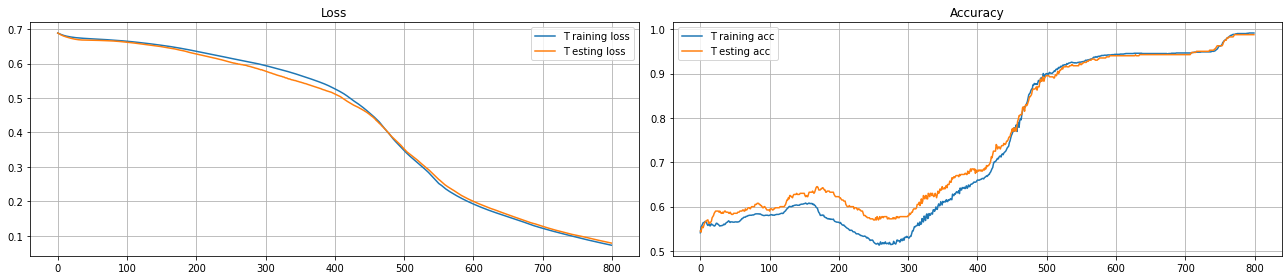

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Plot loss
ax[0].plot(train_loss, label='T raining loss')
ax[0].plot(test_loss, label='T esting loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].grid()

# Plot accuracy
ax[1].plot(train_acc, label='T raining acc')
ax[1].plot(test_acc, label='T esting acc')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

Let's do a little bit more illustrations. We will plot how our model is creating boundaries for these two classes using the code bellow.

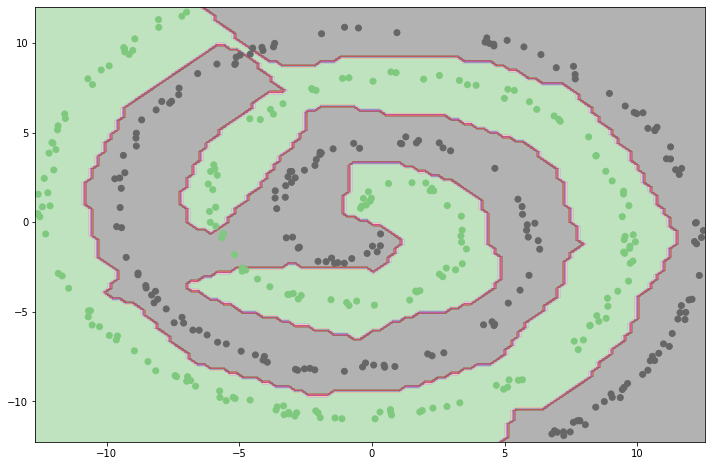

In [ ]:
# Determine grid range in x and y directions
x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1

spacing = min(x_max - x_min, y_max - y_min) / 100 # Set grid spacing parameter

# Create grid
XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
               np.arange(y_min, y_max, spacing))

# Concatenate data to match input
data = np.hstack((XX.ravel().reshape(-1,1), 
                  YY.ravel().reshape(-1,1)))

data_tensor = torch.FloatTensor(data) # Transform to tensor floats 
pred = model(data_tensor) # Pass data to predict

clf = np.where(pred<0.5,0,1)

Z = clf.reshape(XX.shape)

plt.figure(figsize=(12,8))
plt.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.5)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, 
            cmap=plt.cm.Accent)
plt.show()